In [39]:
# COVID 19 model - SEIRH + , along with time varying transmission rate to introduce non-homogenity


using StockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

In [40]:
display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

In [41]:
# define functions ϕ of flows in the SEIRH model
#fNewIncidence(u,p,t)=p.β*u.S*u.I/p.N
# Define the time-varying beta function
function beta(t)
    β0 = 0.8   # Baseline transmission rate
    A = 0.3    # Amplitude of seasonal variation
    T = 365.0  # Period of variation (1 year, 365 days)
    return β0 * (1 + A * sin(2 * π * t / T))
end

# Modify the flow function for new incidence
function fNewIncidence(u, p, t)
    # Using time-varying beta instead of fixed beta
    β_t = beta(t)
    return β_t * u.S * u.I / p.N
end 
fNewInfectious(u,p,t)=u.E*p.ri
fNewRecovery(u,p,t)=u.I/p.tr * (1.0-p.fH )
fWaningImmunityR(u,p,t)=u.R/p.tw
fHICUAdmission(u,p,t) = u.I/p.tr * p.fH * p.fICU
fHNICUAdmission(u,p,t) = u.I/p.tr * p.fH * (1.0-p.fICU)
fOutICU(u,p,t) = u.HICU/p.tICU
fRecoveryH(u,p,t)= u.HNICU/p.tH

# StockAndFlowp(stocks,
#               (flow=>function, upstream=>downstream) => stocks linked)
seirh = StockAndFlowp((:S, :E, :I, :R, :HICU, :HNICU), 
   ((:NewIncidence=>fNewIncidence, :S=>:E) => (:S, :I), 
    (:NewInfectious=>fNewInfectious, :E=>:I) => :E,
    (:NewRecovery=>fNewRecovery, :I=>:R) => :I, 
    (:WaningImmunityR=>fWaningImmunityR, :R=>:S) => :R,
    (:HICUAdmission=>fHICUAdmission, :I=>:HICU) => :I, 
    (:HNICUAdmission=>fHNICUAdmission, :I=>:HNICU) => :I, 
    (:OutICU=>fOutICU, :HICU=>:HNICU) => :HICU,
    (:RecoveryH=>fRecoveryH, :HNICU=>:R) => :HNICU))


StockAndFlowp {Flow:8, Stock:6, Link:9, Name:0, FuncFlow:0}
┌──────┬───┬───┬─────────────────┬──────────────────┐
│ Flow │ u │ d │           fname │               ϕf │
├──────┼───┼───┼─────────────────┼──────────────────┤
│    1 │ 1 │ 2 │    NewIncidence │    fNewIncidence │
│    2 │ 2 │ 3 │   NewInfectious │   fNewInfectious │
│    3 │ 3 │ 4 │     NewRecovery │     fNewRecovery │
│    4 │ 4 │ 1 │ WaningImmunityR │ fWaningImmunityR │
│    5 │ 3 │ 5 │   HICUAdmission │   fHICUAdmission │
│    6 │ 3 │ 6 │  HNICUAdmission │  fHNICUAdmission │
│    7 │ 5 │ 6 │          OutICU │          fOutICU │
│    8 │ 6 │ 4 │       RecoveryH │       fRecoveryH │
└──────┴───┴───┴─────────────────┴──────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     E │
│     3 │     I │
│     4 │     R │
│     5 │  HICU │
│     6 │ HNICU │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 3 │ 1 │
│    3 │ 2 │ 2 │
│    4 │ 3 │ 3 │
│    5 │ 4 │ 4 │
│    6 │ 3 │ 5 │
│    7 │ 3 │ 6 │
│    8 │ 5 │ 7 │
│    9 │ 6 │ 8 │
└──────┴───┴───┘

In [42]:
# Graph(primitive stock-flow model, direction of the diagram - the default value is "LR" from left to right; 
# users could also use "TB" from top to bottom)
Graph(seirh)

LoadError: UndefVarError: `Graph` not defined

In [43]:
# define functions ϕ of flows in the Vaccine model
fFirstdoseVaccine(u,p,t) = u.S * p.rv
fSeconddoseVaccine(u,p,t) = u.VP * p.rv
fWaningImmunityVP(u,p,t) = u.VP / p.tw
fWaningImmunityVF(u,p,t) = u.VF / p.tw
fNewIncidenceVP(u,p,t) = p.β*u.VP*u.I*(1.0-p.eP)/p.N
fNewIncidenceVF(u,p,t) = p.β*u.VF*u.I*(1.0-p.eF)/p.N

# Stock and flow diagram of Vaccine model
v = StockAndFlowp((:S, :E, :I, :VP, :VF), 
   ((:FirstdoseVaccine=>fFirstdoseVaccine, :S=>:VP) => :S, 
    (:SeconddoseVaccine=>fSeconddoseVaccine, :VP=>:VF) => :VP, 
    (:WaningImmunityVP=>fWaningImmunityVP, :VP=>:S) => :VP,
    (:WaningImmunityVF=>fWaningImmunityVF, :VF=>:VP) => :VF,
    (:NewIncidenceVP=>fNewIncidenceVP, :VP=>:E) => (:VP, :I),
    (:NewIncidenceVF=>fNewIncidenceVF, :VF=>:E) => (:VF, :I)))

StockAndFlowp {Flow:6, Stock:5, Link:8, Name:0, FuncFlow:0}
┌──────┬───┬───┬───────────────────┬────────────────────┐
│ Flow │ u │ d │             fname │                 ϕf │
├──────┼───┼───┼───────────────────┼────────────────────┤
│    1 │ 1 │ 4 │  FirstdoseVaccine │  fFirstdoseVaccine │
│    2 │ 4 │ 5 │ SeconddoseVaccine │ fSeconddoseVaccine │
│    3 │ 4 │ 1 │  WaningImmunityVP │  fWaningImmunityVP │
│    4 │ 5 │ 4 │  WaningImmunityVF │  fWaningImmunityVF │
│    5 │ 4 │ 2 │    NewIncidenceVP │    fNewIncidenceVP │
│    6 │ 5 │ 2 │    NewIncidenceVF │    fNewIncidenceVF │
└──────┴───┴───┴───────────────────┴────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     E │
│     3 │     I │
│     4 │    VP │
│     5 │    VF │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 4 │ 2 │
│    3 │ 4 │ 3 │
│    4 │ 5 │ 4 │
│    5 │ 4 │ 5 │
│    6 │ 3 │ 5 │
│    7 │ 5 │ 6 │
│    8 │ 3 │ 6 │
└──────┴───┴───┘

In [44]:
Graph(v,"TB")

LoadError: UndefVarError: `Graph` not defined

In [45]:
# define functions ϕ of flows in the Persist Asymptomaticity model
fNewPersistentAsymptomaticity(u,p,t) = u.E * p.ria
fNewRecoveryIA(u,p,t) = u.IA / p.tr

# Stock and flow diagram of Persistent Asymptomaticity Model
ia = StockAndFlowp((:E, :IA, :R), 
   ((:NewPersistentAsymptomaticity=>fNewPersistentAsymptomaticity, :E=>:IA) => :E, 
    (:NewRecoveryIA=>fNewRecoveryIA, :IA=>:R) => :IA))

StockAndFlowp {Flow:2, Stock:3, Link:2, Name:0, FuncFlow:0}
┌──────┬───┬───┬──────────────────────────────┬───────────────────────────────┐
│ Flow │ u │ d │                        fname │                            ϕf │
├──────┼───┼───┼──────────────────────────────┼───────────────────────────────┤
│    1 │ 1 │ 2 │ NewPersistentAsymptomaticity │ fNewPersistentAsymptomaticity │
│    2 │ 2 │ 3 │                NewRecoveryIA │                fNewRecoveryIA │
└──────┴───┴───┴──────────────────────────────┴───────────────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     E │
│     2 │    IA │
│     3 │     R │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 2 │ 2 │
└──────┴───┴───┘

In [46]:
Graph(ia)

LoadError: UndefVarError: `Graph` not defined

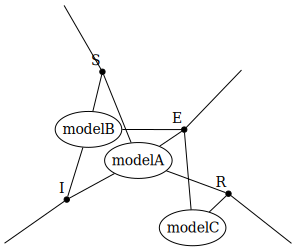

In [47]:
covid = @relation (S, E, I, R) begin
    modelA(S,E,I,R)
    modelB(S,E,I)
    modelC(E,R)
end;
display_uwd(covid)

In [48]:
# Open three Stock and Flow Diagrams
openseirh = Open(seirh, [:S], [:E], [:I], [:R])
openv = Open(v, [:S], [:E], [:I])
openia = Open(ia, [:E], [:R])
# Compose those three models according the UWD-algebra
openCOVID19 = oapply(covid, [openseirh, openv, openia])
# Generate the composed model (Stock and Flow Diagram)
COVID19 = apex(openCOVID19)

Flow,u,d,fname,ϕf
1,1,2,NewIncidence,fNewIncidence
2,2,3,NewInfectious,fNewInfectious
3,3,4,NewRecovery,fNewRecovery
4,4,1,WaningImmunityR,fWaningImmunityR
5,3,5,HICUAdmission,fHICUAdmission
6,3,6,HNICUAdmission,fHNICUAdmission
7,5,6,OutICU,fOutICU
8,6,4,RecoveryH,fRecoveryH
9,1,7,FirstdoseVaccine,fFirstdoseVaccine
10,7,8,SeconddoseVaccine,fSeconddoseVaccine


In [49]:
Graph(COVID19)

LoadError: UndefVarError: `Graph` not defined

In [50]:
# define constant parameters
p_COVID19 = LVector(
    β=0.8, N=38010001.0, tr=12.22, tw=2*365.0,
    fH=0.002, fICU=0.23, tICU=6.0, tH = 12.0,
    rv=0.01, eP=0.6, eF=0.85, ri=0.207, ria=0.138  
)
# define initial values for stocks
u0_COVID19 = LVector(
    S=38010000.0, E=0.0, I=1.0, IA=0.0, R=0.0, HICU=0.0, HNICU=0.0, VP=0.0, VF=0.0
)
     

9-element LArray{Float64, 1, Vector{Float64}, (:S, :E, :I, :IA, :R, :HICU, :HNICU, :VP, :VF)}:
     :S => 3.801e7
     :E => 0.0
     :I => 1.0
    :IA => 0.0
     :R => 0.0
  :HICU => 0.0
 :HNICU => 0.0
    :VP => 0.0
    :VF => 0.0

In [51]:
# check the dependencies of links of all flows' functions
checkfls(COVID19, u0_COVID19, p_COVID19)

LoadError: type LArray{Float64, 1, Vector{Float64}, (:S,)} has no field I

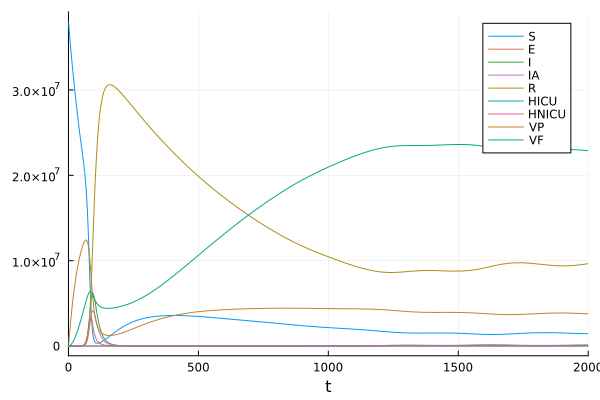

In [52]:
# solve the ODEs
prob_COVID19 = ODEProblem(vectorfield(COVID19),u0_COVID19,(0.0,2000.0),p_COVID19);
sol_COVID19 = solve(prob_COVID19,Tsit5(),abstol=1e-8);
plot(sol_COVID19)